In [1]:
import sys
sys.path.append('/home/kyungtak.lim/gbspy')

import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

# Get the current working directory|
cwd = os.getcwd()

In [26]:
os.chdir('/zhisongqu_data/kyungtak/data_GBS/GBS_SN/nu_scan/SN_nu1')
s=g.Sim()

t_final = 10#s.time[-]
t_init = 0#t_final -1

temp = s.get_field('temperature', t1=t_init, t2=t_final)
dens = s.get_field('n', t1=t_init, t2=t_final)

temp_avg = np.mean(temp, axis=(2,3))
dens_avg  = np.mean(dens, axis=(2,3)); 

Xxpt = s.xxpt
Yxpt = s.yxpt
xmag = s.x0
ymag = s.y0
Psi = s.Psi

Bpol = s.dpsidx_v**2 + s.dpsidy_v**2
Xpt_coord = np.unravel_index(np.argmin(Bpol[Bpol > 0]), s.dpsidx_v.shape)

In [17]:
print(dens.shape)
print(dens_avg.shape)

(324, 244, 80, 101)
(324, 244)


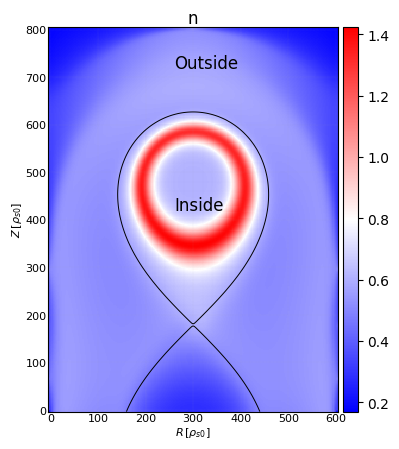

In [15]:
X, Y = np.meshgrid(s.x, s.y)
fig, ax = plt.subplots(figsize=(4, 5), sharex=True, sharey=True)

cs1 = ax.pcolormesh(X, Y, dens_avg, cmap='bwr')
#cs1 = ax.pcolormesh(X, Y, dens_avg, cmap='bwr')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(cs1, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)


ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], linewidths=0.7, colors='k')
ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
ax.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', labelsize=8, pad=1)
ax.tick_params(axis='y', labelsize=8, pad=1)
ax.tick_params(which='minor', direction="in", size=0)
ax.tick_params(which='major', direction="in", size=0)

        
ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=8, labelpad=1)
ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=8, rotation=90, labelpad=1)

ax.text(
    260, 430,                     # (R, Z) location in your plot coordinates
    r'Inside', 
    color='k',
    fontsize=12,
    ha='left', va='center'
)

ax.text(
    260, 730,                     # (R, Z) location in your plot coordinates
    r'Outside', 
    color='k',
    fontsize=12,
    ha='left', va='center'
)

ax.set_title(r'n', fontsize=12, pad=1.5)

#plt.gca().set_aspect('equal')
plt.show(block=False)

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Basic inputs
# ---------------------------------------------------------
Psi  = s.Psi          # (ny, nx)
x    = s.x            # R-grid (nx,)
y    = s.y            # Z-grid (ny,)
dens = dens           # (ny, nx, nphi, nt)

ny, nx, nphi, nt = dens.shape

Xxpt = s.xxpt
Yxpt = s.yxpt
xmag = s.x0
ymag = s.y0

# ---------------------------------------------------------
# 1) Indices for axis and X-point, psi_core / psi_sep
# ---------------------------------------------------------
ix_mag = np.argmin(np.abs(x - xmag))
iy_mag = np.argmin(np.abs(y - ymag))

ix_xpt = np.argmin(np.abs(x - Xxpt))
iy_xpt = np.argmin(np.abs(y - Yxpt))

psi_core = Psi[iy_mag, ix_mag]
psi_sep  = Psi[iy_xpt, ix_xpt]

psi_min = min(psi_core, psi_sep)
psi_max = max(psi_core, psi_sep)

print("psi_core =", psi_core)
print("psi_sep  =", psi_sep)

# ---------------------------------------------------------
# 2) Cell-centered geometry (R,Z only)
# ---------------------------------------------------------
X_nodes, Y_nodes = np.meshgrid(x, y)  # (ny, nx)

Xc = 0.25 * (X_nodes[:-1, :-1] + X_nodes[1:, :-1] +
             X_nodes[:-1,  1:] + X_nodes[1:,  1:])
Yc = 0.25 * (Y_nodes[:-1, :-1] + Y_nodes[1:, :-1] +
             Y_nodes[:-1,  1:] + Y_nodes[1:,  1:])

Psi_c = 0.25 * (Psi[:-1, :-1] + Psi[1:, :-1] +
                Psi[:-1,  1:] + Psi[1:,  1:])

dx = np.diff(x)                     # (nx-1,)
dy = np.diff(y)                     # (ny-1,)
DX, DY = np.meshgrid(dx, dy)        # (ny-1, nx-1)
cell_area = DX * DY                 # dR dZ

inside_mask  = (Psi_c >= psi_min) & (Psi_c <= psi_max)
outside_mask = ~inside_mask

# ---------------------------------------------------------
# 3) Toroidal grid spacing dphi
# ---------------------------------------------------------
# If your sim object has an explicit toroidal grid, use it, e.g.:
# phi = s.phi
# dphi_array = np.diff(phi)  # (nphi-1,)
# dphi = np.mean(dphi_array)

# If phi is uniform and not stored:
dphi = 2.0 * np.pi / nphi

# ---------------------------------------------------------
# 4) Precompute cell-centered density in 4D:
#    dens_c4D: (ny-1, nx-1, nphi, nt)
# ---------------------------------------------------------
dens_c4D = 0.25 * (
    dens[:-1, :-1, :, :] + dens[1:, :-1, :, :] +
    dens[:-1,  1:, :, :] + dens[1:,  1:, :, :]
)

# For 2D (per unit toroidal length) integrals, we will use
# the toroidally-averaged density:
dens_toro = dens.mean(axis=2)  # (ny, nx, nt)

# ---------------------------------------------------------
# 5) Allocate arrays for time evolution
# ---------------------------------------------------------
N2D_inside  = np.zeros(nt)
N2D_outside = np.zeros(nt)
N3D_inside  = np.zeros(nt)
N3D_outside = np.zeros(nt)

# Pre-flatten geometry for 3D integration convenience
inside_flat_idx  = np.where(inside_mask)
outside_flat_idx = np.where(outside_mask)

cell_area_inside  = cell_area[inside_mask]      # (Ncells_in,)
cell_area_outside = cell_area[outside_mask]     # (Ncells_out,)
Xc_inside         = Xc[inside_mask]             # (Ncells_in,)
Xc_outside        = Xc[outside_mask]            # (Ncells_out,)

# ---------------------------------------------------------
# 6) Time loop
# ---------------------------------------------------------
for it in range(nt):
    # ---- 2D per-unit-toroidal integrals (using toroidal average) ----
    dens_t2D = dens_toro[:, :, it]  # (ny, nx)

    dens_c2D = 0.25 * (
        dens_t2D[:-1, :-1] + dens_t2D[1:, :-1] +
        dens_t2D[:-1,  1:] + dens_t2D[1:,  1:]
    )

    N2D_inside[it]  = np.sum(dens_c2D[inside_mask]  * cell_area_inside)
    N2D_outside[it] = np.sum(dens_c2D[outside_mask] * cell_area_outside)

    # ---- 3D integrals: sum over toroidal direction explicitly ----
    # dens_c3D_t: (ny-1, nx-1, nphi)
    dens_c3D_t = dens_c4D[:, :, :, it]

    # Extract only inside/outside cells: → (Ncells_in, nphi), (Ncells_out, nphi)
    dens_inside = dens_c3D_t[inside_mask, :]   # (Ncells_in, nphi)
    dens_outside = dens_c3D_t[outside_mask, :] # (Ncells_out, nphi)

    # Volume element for each cell and toroidal slice:
    # dV = R * dR * dZ * dphi
    # shape (Ncells_in, nphi), (Ncells_out, nphi)
    cell_vol_inside  = (cell_area_inside[:, None]  * Xc_inside[:, None]  * dphi)
    cell_vol_outside = (cell_area_outside[:, None] * Xc_outside[:, None] * dphi)

    # Full 3D particle content:
    N3D_inside[it]  = np.sum(dens_inside  * cell_vol_inside)
    N3D_outside[it] = np.sum(dens_outside * cell_vol_outside)


psi_core = 107655.80286738301
psi_sep  = 115365.98119056014


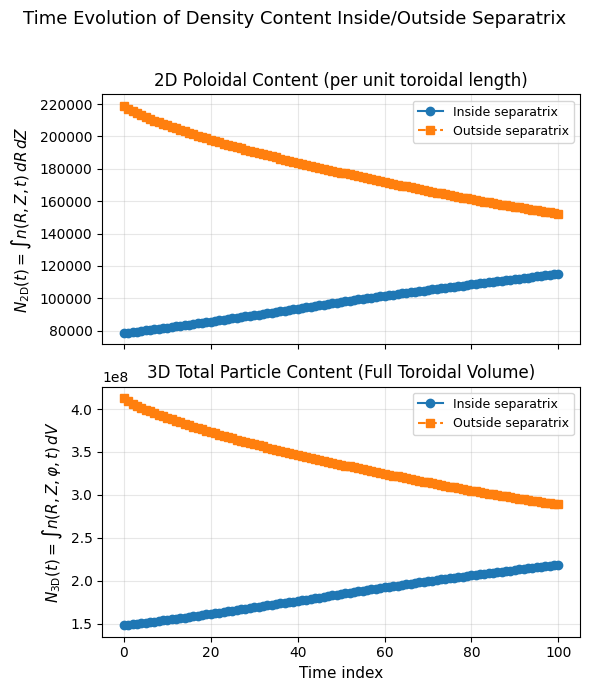

In [36]:
# ---------------------------------------------------------
# 7) Plot time evolution of density integrals (2D and 3D)
# ---------------------------------------------------------

t = np.arange(nt)         # replace with s.time if available
# t = s.time              # e.g., if GBS time is provided

fig, axes = plt.subplots(2, 1, figsize=(6, 7), dpi=100, sharex=True)

# Global figure title
fig.suptitle(
    r'Time Evolution of Density Content Inside/Outside Separatrix',
    fontsize=13, y=0.98
)

# ---------------------------------------------------------
# 2D poloidal integrals (per unit toroidal length)
# ---------------------------------------------------------
axes[0].plot(t, N2D_inside,  'o-', label='Inside separatrix')
axes[0].plot(t, N2D_outside, 's--', label='Outside separatrix')

axes[0].set_ylabel(
    r'$N_{\mathrm{2D}}(t) = \int n(R,Z,t)\, dR\, dZ$',
    fontsize=11
)
axes[0].set_title(r'2D Poloidal Content (per unit toroidal length)', fontsize=12)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# ---------------------------------------------------------
# 3D toroidal integrals (full torus)
# ---------------------------------------------------------
axes[1].plot(t, N3D_inside,  'o-', label='Inside separatrix')
axes[1].plot(t, N3D_outside, 's--', label='Outside separatrix')

axes[1].set_xlabel('Time index', fontsize=11)   # replace by time units if physical time exists
axes[1].set_ylabel(
    r'$N_{\mathrm{3D}}(t)=\int n(R,Z,\varphi,t)\, dV$',
    fontsize=11
)
axes[1].set_title(r'3D Total Particle Content (Full Toroidal Volume)', fontsize=12)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [41]:

# -------------------------------------------------------------------
# Inputs from your simulation
# -------------------------------------------------------------------
Psi  = s.Psi          # (ny, nx)
x    = s.x            # R-grid (nx,)
y    = s.y            # Z-grid (ny,)
dens = dens           # (ny, nx, nphi, nt)  <-- density
temp = temp           # (ny, nx, nphi, nt)  <-- temperature (same shape as dens)

ny, nx, nphi, nt = dens.shape

Xxpt = s.xxpt
Yxpt = s.yxpt
xmag = s.x0
ymag = s.y0

# -------------------------------------------------------------------
# 1) Magnetic axis & X-point indices, psi_core / psi_sep
# -------------------------------------------------------------------
ix_mag = np.argmin(np.abs(x - xmag))
iy_mag = np.argmin(np.abs(y - ymag))

ix_xpt = np.argmin(np.abs(x - Xxpt))
iy_xpt = np.argmin(np.abs(y - Yxpt))

psi_core = Psi[iy_mag, ix_mag]
psi_sep  = Psi[iy_xpt, ix_xpt]

psi_min = min(psi_core, psi_sep)
psi_max = max(psi_core, psi_sep)

print("psi_core =", psi_core)
print("psi_sep  =", psi_sep)

# -------------------------------------------------------------------
# 2) Cell-centered geometry in (R,Z)
# -------------------------------------------------------------------
X_nodes, Y_nodes = np.meshgrid(x, y)  # (ny, nx)

Xc = 0.25 * (X_nodes[:-1, :-1] + X_nodes[1:, :-1] +
             X_nodes[:-1,  1:] + X_nodes[1:,  1:])
Yc = 0.25 * (Y_nodes[:-1, :-1] + Y_nodes[1:, :-1] +
             Y_nodes[:-1,  1:] + Y_nodes[1:,  1:])

Psi_c = 0.25 * (Psi[:-1, :-1] + Psi[1:, :-1] +
                Psi[:-1,  1:] + Psi[1:,  1:])

dx = np.diff(x)                      # (nx-1,)
dy = np.diff(y)                      # (ny-1,)
DX, DY = np.meshgrid(dx, dy)         # (ny-1, nx-1)
cell_area = DX * DY                  # dR dZ

inside_mask  = (Psi_c >= psi_min) & (Psi_c <= psi_max)
outside_mask = ~inside_mask

# Flatten geometry for inside/outside sets
inside_idx   = np.where(inside_mask)
outside_idx  = np.where(outside_mask)

cell_area_inside  = cell_area[inside_mask]      # (Ncells_in,)
cell_area_outside = cell_area[outside_mask]     # (Ncells_out,)
Xc_inside         = Xc[inside_mask]             # (Ncells_in,)
Xc_outside        = Xc[outside_mask]            # (Ncells_out,)

# -------------------------------------------------------------------
# 3) Toroidal spacing dphi
# -------------------------------------------------------------------
# If you have explicit toroidal coordinates, use those:
# phi = s.phi  # (nphi,)
# dphi_array = np.diff(phi)
# dphi = np.mean(dphi_array)

# Otherwise, assume uniform grid:
dphi = 2.0 * np.pi / nphi

# -------------------------------------------------------------------
# 4) Cell-centered 4D density and temperature: (ny-1, nx-1, nphi, nt)
# -------------------------------------------------------------------
dens_c4D = 0.25 * (
    dens[:-1, :-1, :, :] + dens[1:, :-1, :, :] +
    dens[:-1,  1:, :, :] + dens[1:,  1:, :, :]
)

temp_c4D = 0.25 * (
    temp[:-1, :-1, :, :] + temp[1:, :-1, :, :] +
    temp[:-1,  1:, :, :] + temp[1:,  1:, :, :]
)

# -------------------------------------------------------------------
# 5) Thermal energy density and volume integration
# -------------------------------------------------------------------
# Physical factor: 3/2 * e for species in eV units
e_charge = 1
alpha = 1.5 * e_charge    # for one species, W = alpha * n * T  [J/m^3]
# If you want total electrons+ions, you can set alpha = 3 * e_charge

W_inside  = np.zeros(nt)   # energy content inside sep
W_outside = np.zeros(nt)   # energy content outside sep

for it in range(nt):
    # energy density at this time: eps = alpha * n * T
    eps_t = alpha * dens_c4D[:, :, :, it] * temp_c4D[:, :, :, it]  # (ny-1, nx-1, nphi)

    # select inside/outside: (Ncells_in, nphi), (Ncells_out, nphi)
    eps_inside  = eps_t[inside_mask, :]    # (Ncells_in, nphi)
    eps_outside = eps_t[outside_mask, :]   # (Ncells_out, nphi)

    # volume element per cell and toroidal slice: dV = R * dR * dZ * dphi
    cell_vol_inside  = cell_area_inside[:, None]  * Xc_inside[:, None]  * dphi
    cell_vol_outside = cell_area_outside[:, None] * Xc_outside[:, None] * dphi

    # integrate energy content:
    W_inside[it]  = np.sum(eps_inside  * cell_vol_inside)
    W_outside[it] = np.sum(eps_outside * cell_vol_outside)

# -------------------------------------------------------------------
# 6) Compute power as time derivative: P = dW/dt
# -------------------------------------------------------------------
# If you have a physical time array, use it here:
# t = s.time  # shape (nt,)
t = np.arange(nt)  # fallback: just indices

# Use np.gradient to get dW/dt
P_inside  = np.gradient(W_inside,  t)
P_outside = np.gradient(W_outside, t)

psi_core = 107655.80286738301
psi_sep  = 115365.98119056014


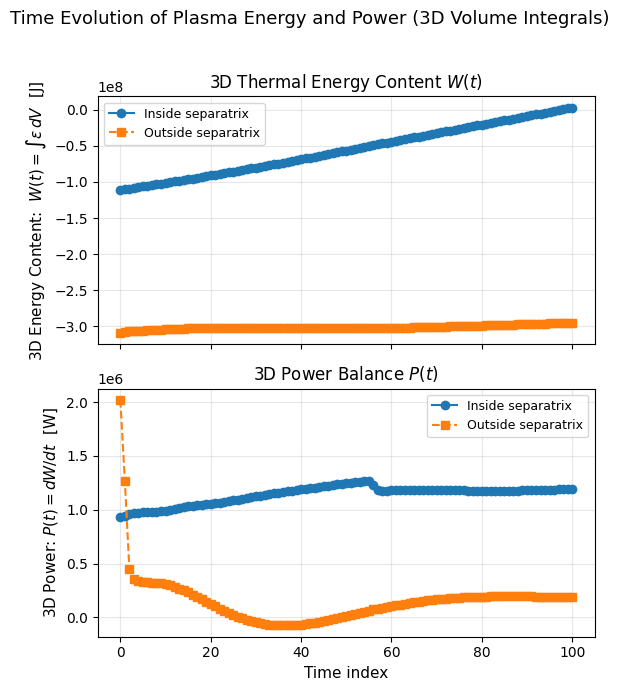

In [42]:
# -------------------------------------------------------------------
# 7) Plot energy content (3D) and power (3D) vs time
# -------------------------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(6, 7), dpi=100, sharex=True)

# Figure title
fig.suptitle(r'Time Evolution of Plasma Energy and Power (3D Volume Integrals)', 
             fontsize=13, y=0.98)

# ------------------------
# (1) Total energy W(t)
# ------------------------
axes[0].plot(t, W_inside,  'o-', label='Inside separatrix')
axes[0].plot(t, W_outside, 's--', label='Outside separatrix')

axes[0].set_ylabel(
    r'3D Energy Content:  $W(t) = \int \varepsilon\, dV$  [J]',
    fontsize=11
)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_title(r'3D Thermal Energy Content $W(t)$', fontsize=12)

# ------------------------
# (2) Power P(t)
# ------------------------
axes[1].plot(t, P_inside,  'o-', label='Inside separatrix')
axes[1].plot(t, P_outside, 's--', label='Outside separatrix')

axes[1].set_xlabel('Time index', fontsize=11)   # replace with physical units if available
axes[1].set_ylabel(
    r'3D Power: $P(t) = dW/dt$  [W]',
    fontsize=11
)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_title(r'3D Power Balance $P(t)$', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
